# Least Squares Policy Iteration

In [208]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [209]:
plt.rcParams["figure.figsize"] = 10, 6

In [210]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment

Let's get a really simple environment going -- we'll try to replicate
the paper's results with the [NChain-v0](https://gym.openai.com/envs/NChain-v0/) 
environment.  The environment wrapped up in OpenAI puts a large reward at the
end of the chain, so the optimal strategy is always to go right.  The problem
is made slightly more difficult in that there is a high probability of 
movement error, and you always receive a small reward for going left.

We can solve this pretty easily (1-3 iterations of LSPI with only quadratic 
basis functions).

In [211]:
import gym

In [212]:
length = 10

env = gym.make('NChain-v0', n=length)
env.reset()

0

In [213]:
env.action_space

Discrete(2)

In [214]:
env.observation_space

Discrete(10)

In [215]:
obs, reward, done, _ = env.step(0)

## LSTDQ: Least Squares Temporal Difference Q-Learning

In [216]:
import abc

class Policy(object, metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def __call__(self, state):
        """
        Returns an action to take given a state.
        """
        pass
    
    @abc.abstractmethod
    def update(self, weights) -> float:
        """
        Returns the "difference" between the current weights, and new weights.
        """
        pass
    
class RandomPolicy(Policy):
    
    def __init__(self, env: gym.Env):
        """
        Creates a random policy.
        """
        self._env = env
        
    def __call__(self, state):
        assert(state in self._env.observation_space)
        return self._env.action_space.sample()
    
    def update(self, weights):
        return 0.0

In [217]:
from typing import Iterable, List
from numpy.linalg import LinAlgError

class LSTDQ(object):
    
    def __init__(self, bases, discount = 0.9, gamma = 1e-3):
        
        self._bases = bases
        self._k = len(bases)
        self._discount = discount
        self._gamma = gamma
        
    def fit(self, data: Iterable, policy: Policy):
        """
        Performs an iteration of LSTDQ.  
        """
        
        A = np.eye(self._k) * self._gamma
        b = np.zeros((self._k,))
        
        for state, action, reward, nextstate in data:
            phi = np.array([basis(state, action) for basis in self._bases])
            phiprime = np.array([basis(nextstate, policy(nextstate)) for basis in self._bases])
            
            A += np.outer(phi, phi - self._discount * phiprime)
            b += reward * phi
            
        try:
            self.weights_ = np.linalg.inv(A) @ b
        except LinAlgError as e:
            print(f"A is uninvertable:\n {A}")
            self.weights_ = np.zeros((self._k,))
        
        return self

In [218]:
def generate_sample_data(num_samples, env: gym.Env, policy: Policy):
    
    state = env.reset()
    
    data = []
    
    for _ in range(int(num_samples)):
        action = policy(state)
        
        nextstate, reward, done, _ = env.step(action)
        
        data.append((state, action, reward, nextstate))
        state = nextstate
        
    return data

In [219]:
simple_chain_bases = [
    lambda s, a: a * 1,
    lambda s, a: a * s,
    lambda s, a: a * s**2,
    lambda s, a: (1 - a) * 1,
    lambda s, a: (1 - a) * s,
    lambda s, a: (1 - a) * s**2,
]

In [220]:
data = generate_sample_data(1e3, env, RandomPolicy(env))

lstdq = LSTDQ(simple_chain_bases, discount=0.1)
lstdq = lstdq.fit(data, RandomPolicy(env))

In [221]:
class DiscreteActionBasisPolicy(Policy):
    
    def __init__(self, space: gym.spaces.Discrete, bases: List, weights: np.ndarray):
        
        self._space = space
        
        assert(len(bases) == len(weights))
        self._bases = bases
        self._weights = weights
        
        self.history_ = [self._weights]
        
    def __call__(self, state):
        """
        Returns the optimal action at this state.
        """
        
        qvalues = np.zeros(self._space.n)
        for action in range(self._space.n):
            phi = np.array([basis(state, action) for basis in self._bases])
            qvalues[action] = phi @ self._weights
            
        return np.argmax(qvalues)
    
    def update(self, weights):
        """
        Updates the weights of this policy.
        """
        
        self.history_.append(weights)
        
        diff = np.linalg.norm(self._weights - weights)
        self._weights = weights
        return diff

In [222]:
dabp = DiscreteActionBasisPolicy(env.action_space, simple_chain_bases, lstdq.weights_)
dabp(1)

1

In [296]:
class LSPI(object):
    
    def __init__(self, optimizer: LSTDQ, policy: Policy, max_iter = 50, epsilon = 1e-3):
        
        self._optimizer = optimizer
        self._policy = policy
        
        self._max_iter = max_iter
        self._epsilon = epsilon
        
    def fit(self, data: List):
        
        for self.itr_ in range(self._max_iter):
            self._optimizer.fit(data, self._policy)
            diff = self._policy.update(self._optimizer.weights_)
#             print(self._optimizer.weights_)
#             print(diff)
            if (diff < self._epsilon):
                break
                
        return self
    
    @property
    def policy(self):
        return self._policy

## Running LSPI on OpenAI's NChain-v0 environment

In [297]:
data = generate_sample_data(1e3, env, RandomPolicy(env))
lstdq = LSTDQ(simple_chain_bases, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, simple_chain_bases, np.zeros(len(simple_chain_bases)))

In [298]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-5)
lspi.fit(data)

In [299]:
lspi.itr_

3

In [300]:
for state in range(env.observation_space.n):
    print(lspi.policy(state))

0
0
0
0
0
1
1
1
1
1


As desired, the learned optimal action for all states is to move to the right.

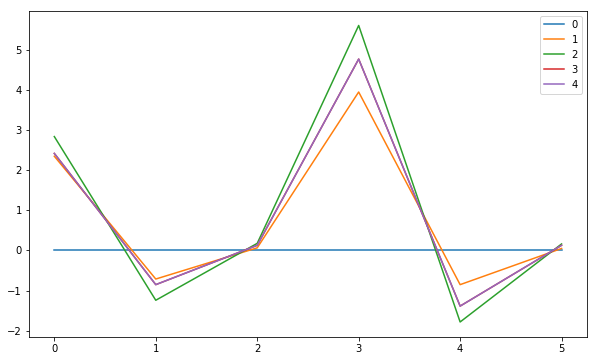

In [301]:
for ind, line in enumerate(lspi.policy.history_):
    plt.plot(line, label=f"{ind}")
plt.legend()

## More complicated chain problems

In the [LSPI paper](https://www2.cs.duke.edu/research/AI/LSPI/) they test on some more complex chains:  

* chains with rewards on either end 
* chains with rewards in the middle

I grabbed [the NChain-v0 code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/nchain.py)
from OpenAI's github, and modified it 
to support chains of this structure in the file 
[environments.py](./environments.py).

In [311]:
from environments import NChainEnv

length = 10

reward = np.zeros(length)
reward[1] = 1
reward[9] = 1

env = NChainEnv(reward, slip=0.0, wrap=False)

In [312]:
data = generate_sample_data(1e4, env, RandomPolicy(env))
lstdq = LSTDQ(simple_chain_bases, discount=0.8)
dabp = DiscreteActionBasisPolicy(env.action_space, simple_chain_bases, np.zeros(len(simple_chain_bases)))

In [313]:
lspi = LSPI(lstdq, dabp, max_iter=100, epsilon=1e-3)
lspi.fit(data)

In [314]:
lspi.itr_

4

In [316]:
policy = [lspi.policy(state) for state in range(env.observation_space.n)]
policy

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [317]:
expected = [1, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [318]:
policies = []
for test in range(20):
    lspi.fit(data)
    policy = [lspi.policy(state) for state in range(env.observation_space.n)]
    policies.append(policy)

In [319]:
np.mean([pol == expected for pol in policies])

0.0

## Cartpole

In [324]:
env = gym.make("CartPole-v0")

In [325]:
env

<TimeLimit<CartPoleEnv<CartPole-v0>>>

In [326]:
env.action_space

Discrete(2)

In [327]:
env.observation_space

Box(4,)

In [328]:
data = generate_sample_data(1e3, env, RandomPolicy(env))
lstdq = LSTDQ(simple_chain_bases, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, simple_chain_bases, np.zeros(len(simple_chain_bases)))

/opt/conda/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


AssertionError: 

In [298]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-5)
lspi.fit(data)

In [299]:
lspi.itr_

3